In [1]:
from FeatureEngineering import *
from sklearn.metrics import precision_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = my_read_csv('train_data.csv')
test_data = my_read_csv('test_data.csv')

In [29]:
X_train,y_train = train_data.loc[:,train_data.columns != 'TARGET'],train_data.loc[:,['TARGET']]
X_test,y_test = test_data.loc[:,test_data.columns != 'TARGET'],test_data.loc[:,['TARGET']]

In [30]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [ ]:
train_data.isnull().sum().sum()

0

In [5]:
def evaluate(estimator, X_test, y_test, X_train, y_train):
    y_pre_train = estimator.predict(X_train)
    recall_train = recall_score(y_train, y_pre_train)
    precision_train = precision_score(y_train, y_pre_train)
    y_pre_test = estimator.predict(X_test)
    recall_test = recall_score(y_test, y_pre_test)
    y_pre_prob_train = estimator.predict_proba(X_train)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_pre_prob_train)
    acc_train = accuracy_score(y_train, y_pre_train)
    y_pre_prob_test = estimator.predict_proba(X_test)[:, 1]
    precision_test = precision_score(y_test, y_pre_test)
    acc_test = accuracy_score(y_test, y_pre_test)
    roc_auc_test = roc_auc_score(y_test, y_pre_prob_test)
    train_ev_list = [recall_train, precision_train, roc_auc_train,acc_train]
    test_ev_list = [recall_test,precision_test,roc_auc_test,acc_test]
    ev_df = pd.DataFrame(data = [train_ev_list, test_ev_list], index=['Train','Test'], columns = ['Recall score','Precision','Roc-auc score','Accuracy']).T
    plot_confusion_matrix(clf, X_test, y_test)
    return ev_df.round(4)



The evaluation matrix for Decision Tree

,Train,Test
Recall score,0.3209,0.3349
Precision,0.8023,0.7200
Roc-auc score,0.8765,0.8550
Accuracy,0.9444,0.9417


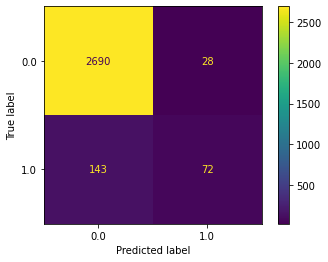

In [40]:
clf = LogisticRegression(random_state=0, C=100)
clf.fit(X_train, y_train)
evaluate(clf, X_test, y_test, X_train, y_train)

Without colinearity

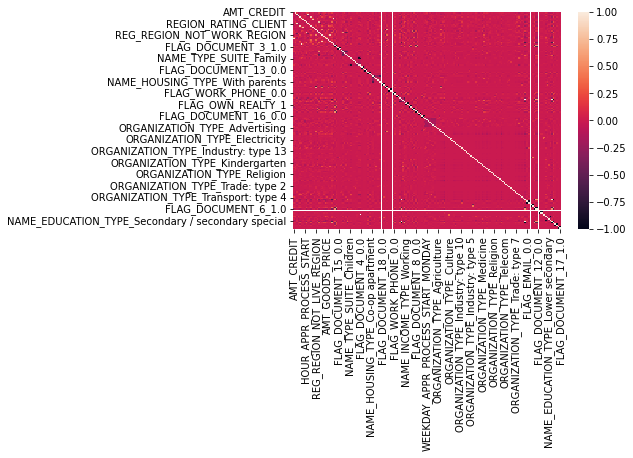

In [31]:
sns.heatmap(X.corr())

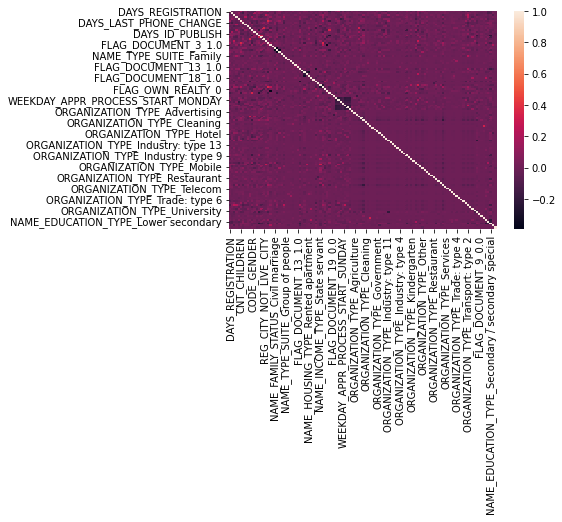

In [32]:
# !pip install collinearity
from sklearn.pipeline import make_pipeline
from collinearity import SelectNonCollinear
selector = SelectNonCollinear(correlation_threshold=0.4,scoring=f_classif)
X_column = X.columns
X = X.values
y = y.values
selector.fit(X,y)
mask = selector.get_support()
X_preprprocessed = pd.DataFrame(X[:,mask],columns = np.array(X_column)[mask])
sns.heatmap(X_preprprocessed.corr())

After deleting colinearity, the result is still bad

,Train,Test
Recall score,0.3256,0.2977
Precision,0.8069,0.7111
Roc-auc score,0.8717,0.8492
Accuracy,0.9448,0.9397


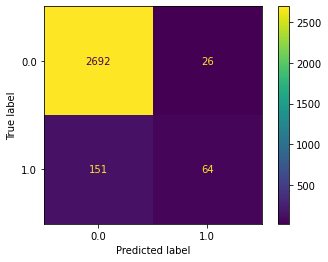

In [39]:
x_vars = X_preprprocessed.columns
X_train_2,X_test_2 = X_train.loc[:,x_vars],X_test.loc[:,x_vars]
clf = LogisticRegression(random_state=0, C=100)
clf.fit(X_train_2, y_train)
evaluate(clf, X_test_2, y_test, X_train_2, y_train)

## Tune Logistic Regression

### What's a good C?

In [43]:
reg_list = [0.01,0.1,0.15,0.2,0.4, 0.5, 1, 10, 100]
recall_list = []
for reg_value in reg_list:
    lr = LogisticRegression(C=reg_value)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    recall = recall_score(y_test,y_pred)
    recall_list.append(recall)
evaluation_df = pd.DataFrame(index=['C='+ str(i) for i in reg_list], data=recall_list,columns=['Recall']).T
max_c  = evaluation_df.idxmax(axis=1).values[0]
print("The best C that gives the best recall score is: {}".format(max_c))
evaluation_df

The best C that gives the best recall score is: C=100


,C=0.01,C=0.1,C=0.15,C=0.2,C=0.4,C=0.5,C=1,C=10,C=100
Recall,0.0,0.176744,0.176744,0.237209,0.237209,0.311628,0.311628,0.330233,0.334884


,Train,Test
Recall score,1.0,0.7907
Precision,1.0,1.0000
Roc-auc score,1.0,0.9856
Accuracy,1.0,0.9847


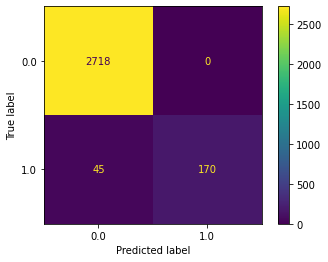

In [ ]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
evaluate(clf, X_test, y_test, X_train, y_train)

In [44]:
print(clf.get_params())

{'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
